Prix téléchargés: 4025 dates x 100 tickers


/tmp/ipython-input-1589356260.py:117: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  anchor = prices.resample("M").last().index
/tmp/ipython-input-1589356260.py:229: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = hist_prices.pct_change()
/tmp/ipython-input-1589356260.py:229: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = hist_prices.pct_change()
/tmp/ipython-input-1589356260.py:229: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in


=== Variante A : Equal-weight (score risk-adjust) ===
- CAGR: 0.0470
- Total Return: 1.0861
- Volatility (ann.): 0.0807
- Sharpe (ann.): 0.6108
- Max Drawdown: -0.1477
- Avg Net Exposure: 0.4000
- Avg Gross Exposure: 1.0000
- Avg Turnover: 0.6135


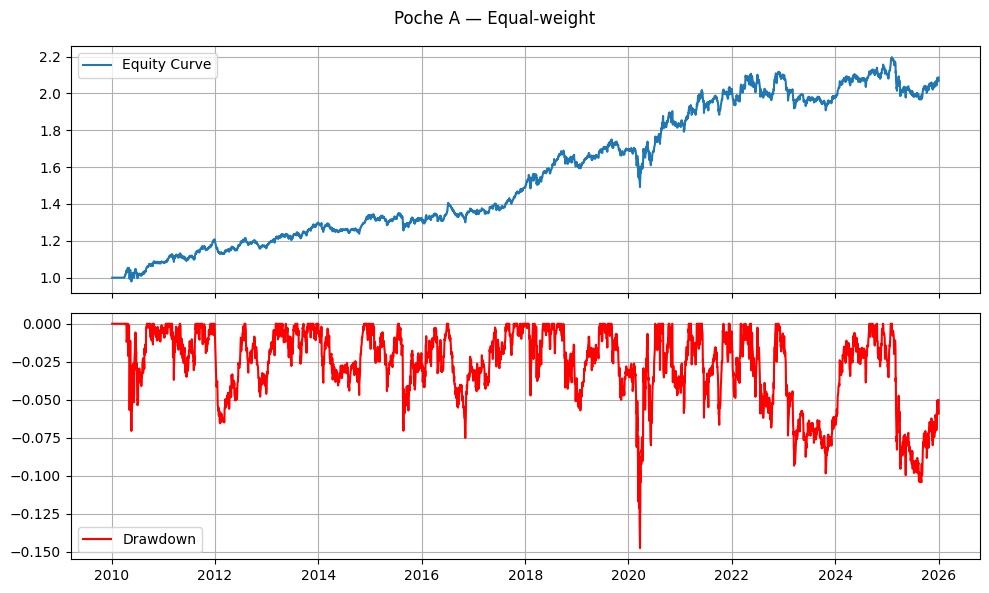

/tmp/ipython-input-1589356260.py:117: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  anchor = prices.resample("M").last().index
/tmp/ipython-input-1589356260.py:229: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = hist_prices.pct_change()
/tmp/ipython-input-1589356260.py:229: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = hist_prices.pct_change()
/tmp/ipython-input-1589356260.py:229: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in


=== Variante B : Inverse-vol + rank (score non risk-adjust) ===
- CAGR: 0.0807
- Total Return: 2.4610
- Volatility (ann.): 0.0993
- Sharpe (ann.): 0.8329
- Max Drawdown: -0.1234
- Avg Net Exposure: 0.4000
- Avg Gross Exposure: 1.0000
- Avg Turnover: 0.7640


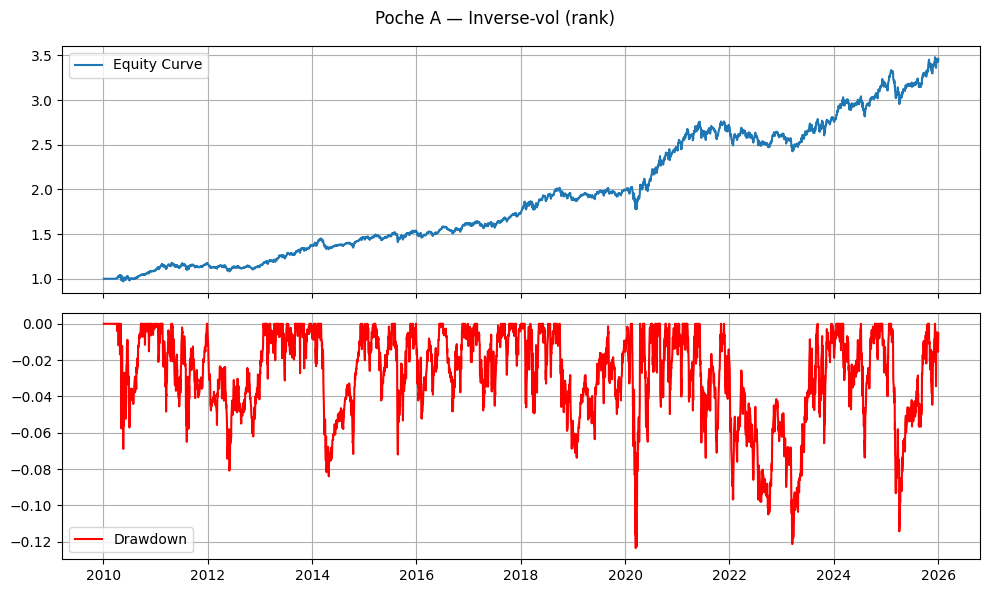


Fichiers de poids sauvegardés :
- signals/weights_equal_2026-01-02.csv
- signals/weights_invvol_2026-01-02.csv

Top 10 — Variante A (equal) :
        weight
Ticker        
AAPL     0.035
ABBV     0.035
C        0.035
BK       0.035
CVS      0.035
FDX      0.035
BAC      0.035
SPG      0.035
USB      0.035
XOM      0.035

Top 10 — Variante B (invvol, rank) :
          weight
Ticker          
AAPL    0.074150
TMO     0.048282
MS      0.044131
BK      0.043913
RTX     0.042330
C       0.041902
JNJ     0.041234
GOOGL   0.039808
LLY     0.039363
GOOG    0.039318


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Téléchargement des CSV lancé (penser à autoriser les pop-ups).


In [2]:
# ============================
# Imports
# ============================

import os
import math
import datetime as dt
from typing import List, Optional, Tuple, Dict

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# ============================
# Configuration
# ============================

# Univers de travail : gros titres US type S&P100 (liste approximative, modifiable)
UNIVERSE = [
    "AAPL","ABBV","ABT","ACN","ADBE","AIG","AMD","AMGN","AMT","AMZN","AVGO","AXP","BA","BAC","BK",
    "BKNG","BLK","BMY","BRK-B","C","CAT","CL","CMCSA","COF","COP","COST","CRM","CSCO","CVS","CVX",
    "DE","DHR","DIS","DUK","EMR","FDX","GD","GE","GILD","GM","GOOG","GOOGL","GS","HD","HON","IBM",
    "INTC","INTU","ISRG","JNJ","JPM","KO","LIN","LLY","LMT","LOW","MA","MCD","MDLZ","MDT","MET",
    "META","MMM","MRK","MS","MSFT","NEE","NFLX","NKE","NOW","NVDA","ORCL","PEP","PFE","PG","PLTR",
    "PM","PYPL","QCOM","RTX","SBUX","SCHW","SO","SPG","T","TGT","TMO","TMUS","TSLA","TXN","UBER",
    "UNH","UNP","UPS","USB","V","VZ","WFC","WMT","XOM"
]

START_DATE = "2010-01-01"
END_DATE   = None  # si None -> télécharge jusqu’à aujourd’hui

# Paramètres du signal "Poche A"
ROC_WINDOW        = 126   # env. 6 mois de lookback pour le ROC
MA_SHORT          = 50    # moyenne mobile "rapide"
MA_LONG           = 200   # moyenne mobile "lente" (tendance long terme)
VOL_SIGMA_WINDOW  = 60    # fenêtre pour la volatilité utilisée dans le score
RSI_WINDOW        = 14    # RSI classique 14 jours

# Sélection long/short (en pourcentage de l’univers)
TOP_PCT     = 0.2        # 20% meilleurs scores -> candidats long
BOTTOM_PCT  = 0.4        # 40% plus mauvais scores -> pool pour les shorts
MIN_NAMES   = 3          # au moins 3 titres par côté pour éviter un portefeuille trop concentré

# Exposition globale (ici portefeuille tilté long : 70/30)
LONG_EXPOSURE  = 0.7
SHORT_EXPOSURE = 0.3

# Fenêtre de vol pour le sizing inverse-vol (quand activé)
VOL_WINDOW = 20          # environ 1 mois de bourse

# Fréquence de rebalancement et coûts de transaction
REBAL_FREQ = "M"         # rebal mensuel (fin de mois)
TC_BPS     = 8.0         # coût de transaction (8 bps * turnover)

# Cap par ligne (si None, pas de limite individuelle)
MAX_WEIGHT = None        # ex. 0.15 pour caper à 15% par ligne

# Dossier pour les CSV de poids
OUT_DIR = "signals"
DOWNLOAD_WEIGHTS = True  # pratique dans Colab pour récupérer les fichiers

# ============================
# Fonctions utilitaires
# ============================

def get_prices_and_volume(
    tickers: List[str],
    start: str,
    end: Optional[str] = None
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Télécharge prix ajustés + volumes via yfinance.
    Retour : (DataFrame prix, DataFrame volumes) indexés par dates.
    """
    if end is None:
        end = dt.date.today().isoformat()
    raw = yf.download(" ".join(tickers), start=start, end=end,
                      progress=False, auto_adjust=True)
    if raw.empty:
        raise ValueError("Téléchargement vide. Vérifier tickers ou période.")

    # Gestion du format yfinance (multi-index ou pas)
    if isinstance(raw.columns, pd.MultiIndex):
        close  = raw["Close"].copy()
        volume = raw["Volume"].copy()
        close.columns  = close.columns.get_level_values(-1)
        volume.columns = volume.columns.get_level_values(-1)
    else:
        if "Close" not in raw.columns or "Volume" not in raw.columns:
            raise ValueError("Je ne trouve pas 'Close' ou 'Volume' dans les données.")
        close  = raw[["Close"]].copy()
        volume = raw[["Volume"]].copy()
        close.columns  = [tickers[0]]
        volume.columns = [tickers[0]]

    close  = close.dropna(how="all").sort_index()
    volume = volume.dropna(how="all").sort_index()

    # Je force l’ordre des colonnes = UNIVERSE et je rajoute des NaN si un ticker manque
    for t in tickers:
        if t not in close.columns:
            close[t] = np.nan
        if t not in volume.columns:
            volume[t] = np.nan

    return close[tickers], volume[tickers]


def get_rebalance_dates(prices: pd.DataFrame, freq: str = "M") -> pd.DatetimeIndex:
    """
    Construit les dates de rebalancement à partir de l’index des prix
    (par ex. fin de mois), puis les mappe sur les derniers jours de bourse disponibles.
    """
    idx = prices.index
    if freq == "M":
        anchor = prices.resample("M").last().index
    elif freq == "W-FRI":
        anchor = prices.resample("W-FRI").last().index
    else:
        anchor = prices.resample(freq).last().index

    pos = idx.get_indexer(anchor, method="pad")
    pos = [p for p in pos if p != -1]
    return idx[pos]


def performance_metrics(daily_returns: pd.Series) -> Dict[str, float]:
    """
    Calcule les stats classiques sur la série de rendements quotidiens :
    CAGR, volatilité annualisée, Sharpe, drawdown max.
    """
    r = daily_returns.dropna()
    if r.empty:
        return {}
    cum = (1 + r).cumprod()
    total_days = (r.index[-1] - r.index[0]).days if len(r) > 1 else 0
    years = total_days / 365.25 if total_days > 0 else np.nan
    total_return = float(cum.iloc[-1] - 1.0) if len(cum) > 0 else np.nan
    cagr = float(cum.iloc[-1] ** (1/years) - 1.0) if years and years > 0 else np.nan
    vol = float(r.std() * math.sqrt(252)) if len(r) > 1 else np.nan
    sharpe = float((r.mean()*252)/vol) if vol and vol > 1e-9 else np.nan
    dd = cum / cum.cummax() - 1.0
    max_dd = float(dd.min()) if len(dd) > 0 else np.nan
    return {
        "CAGR": cagr,
        "Total Return": total_return,
        "Volatility (ann.)": vol,
        "Sharpe (ann.)": sharpe,
        "Max Drawdown": max_dd,
    }


def plot_equity_and_drawdown(daily_returns: pd.Series, title: str = "Equity & Drawdown"):
    """
    Petit helper pour tracer la courbe de performance cumulée + drawdown.
    """
    equity = (1 + daily_returns.fillna(0.0)).cumprod()
    dd = equity / equity.cummax() - 1.0
    fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    ax[0].plot(equity.index, equity.values, label="Equity Curve")
    ax[0].grid(True); ax[0].legend()
    ax[1].plot(dd.index, dd.values, label="Drawdown", color="red")
    ax[1].grid(True); ax[1].legend()
    plt.suptitle(title); plt.tight_layout(); plt.show()

# ============================
# Signal Momentum
# ============================

def momentum_scores_pocheA(
    prices: pd.DataFrame,
    volumes: pd.DataFrame,
    lookback_days: int,
    as_of_date: Optional[pd.Timestamp] = None,
    roc_window: int = ROC_WINDOW,
    ma_short: int = MA_SHORT,
    ma_long: int = MA_LONG,
    vol_window: int = VOL_SIGMA_WINDOW,
    rsi_window: int = RSI_WINDOW,
    w_roc: float = 0.7,
    w_ma: float = 0.3,
    rsi_penalty_level: float = 80.0,
    rsi_penalty_factor: float = 0.5,
    risk_adjust_by_vol: bool = True,  # je mets False si je préfère gérer le low-vol dans les poids
) -> pd.Series:
    """
    Construction du score “Poche A”.

    - ROC sur 6 mois
    - MA50 / MA200 (tendance)
    - éventuellement division par la vol (score risk-adjust)
    - pénalité RSI si sur-achat
    - pénalité si le titre traite sur des volumes faibles
    - si on n’a pas assez d’historique : on retombe sur un simple momentum lookback.
    """
    prices  = prices.dropna(how="all").sort_index()
    volumes = volumes.dropna(how="all").sort_index()
    if as_of_date is None:
        as_of_date = prices.index.max()
    if as_of_date not in prices.index:
        as_of_date = prices.index[prices.index.get_loc(as_of_date, method="pad")]

    idx_pos = prices.index.get_loc(as_of_date)
    required = max(ma_long, roc_window, vol_window, rsi_window)

    # Pas assez d’historique : je reviens sur un bête momentum simple
    if idx_pos < required:
        if idx_pos < lookback_days:
            return pd.Series(dtype=float)
        current = prices.iloc[idx_pos]
        past    = prices.shift(lookback_days).iloc[idx_pos]
        return (current / past - 1.0).replace([np.inf, -np.inf], np.nan).dropna()

    hist_prices  = prices.iloc[: idx_pos + 1]
    hist_volumes = volumes.iloc[: idx_pos + 1]

    # ROC 6 mois
    price_now = hist_prices.iloc[-1]
    price_roc = hist_prices.shift(roc_window).iloc[-1]
    roc = (price_now / price_roc) - 1.0

    # Ratio MA50 / MA200 (>1 => prix au-dessus de la tendance longue)
    ma_s = hist_prices.rolling(ma_short).mean().iloc[-1]
    ma_l = hist_prices.rolling(ma_long).mean().iloc[-1]
    ma_ratio = (ma_s / ma_l)

    # Volatilité (pour éventuellement diviser le score)
    returns = hist_prices.pct_change()
    vol = returns.rolling(vol_window).std().iloc[-1]

    # RSI 14 jours
    delta = hist_prices.diff()
    gain  = delta.clip(lower=0.0)
    loss  = -delta.clip(upper=0.0)
    avg_gain = gain.rolling(rsi_window).mean().iloc[-1]
    avg_loss = loss.rolling(rsi_window).mean().iloc[-1]
    rs  = avg_gain / avg_loss
    rsi = 100.0 - (100.0 / (1.0 + rs))

    # Volume moyen sur 60 jours pour détecter les trucs trop illiquides
    avg_volume = hist_volumes.rolling(60).mean().iloc[-1]

    # Nettoyage des valeurs bizarres
    roc = roc.replace([np.inf, -np.inf], np.nan)
    ma_ratio = ma_ratio.replace([np.inf, -np.inf], np.nan)
    vol = vol.replace([np.inf, -np.inf, 0.0], np.nan)
    rsi = rsi.replace([np.inf, -np.inf], np.nan)
    avg_volume = avg_volume.replace([np.inf, -np.inf], np.nan)

    # Je transforme ROC et MA_ratio en rangs cross-section
    rank_roc = roc.rank(pct=True, ascending=True)
    rank_ma = ma_ratio.rank(pct=True, ascending=True)
    score_base = w_roc * rank_roc + w_ma * rank_ma

    # Option : j’ajuste le score par 1/vol pour avoir un truc risk-adjusted
    score_adj = score_base / (vol + 1e-8) if risk_adjust_by_vol else score_base

    # Pénalité RSI et volume
    penalty = pd.Series(1.0, index=score_adj.index)
    penalty[rsi > rsi_penalty_level] = rsi_penalty_factor        # titre suracheté
    penalty[(avg_volume < 500_000).fillna(False)] *= 0.5         # très peu liquide

    score_final = (score_adj * penalty).replace([np.inf, -np.inf], np.nan).dropna()
    return score_final

# ============================
# Passage des scores aux poids
# ============================

def compute_weights_from_scores(
    scores: pd.Series,
    returns: Optional[pd.DataFrame] = None,
    vol_window: int = VOL_WINDOW,
    top_pct: float = TOP_PCT,
    bottom_pct: float = BOTTOM_PCT,
    long_exposure: float = LONG_EXPOSURE,
    short_exposure: float = SHORT_EXPOSURE,
    vol_scale: bool = False,
    max_weight: Optional[float] = MAX_WEIGHT,
    min_names_per_side: int = MIN_NAMES,
    weight_scheme: str = "rank_inv_vol",  # "equal" | "inv_vol" | "rank" | "rank_inv_vol" | "zscore_inv_vol"
    winsor_k: float = 3.0,
) -> pd.Series:
    """
    À partir des scores cross-section :
    - je prends top/bottom selon TOP_PCT / BOTTOM_PCT
    - puis je construis les poids selon le schéma choisi (equal, inverse-vol, rank, etc.)
    - enfin je renormalise pour que la somme des longs = LONG_EXPOSURE et des shorts = SHORT_EXPOSURE.
    """
    scores = scores.dropna()
    if scores.empty:
        return pd.Series(dtype=float, index=scores.index)

    n = len(scores)
    n_top = max(min_names_per_side, math.floor(n * top_pct))
    n_bottom = max(min_names_per_side, math.floor(n * bottom_pct))
    top = scores.nlargest(n_top).index
    bottom = scores.nsmallest(n_bottom).index

    # Rang percentiles [0,1] pour pouvoir faire des poids “plus le score est extrême, plus le poids est gros”
    r = scores.rank(pct=True, ascending=True)

    if weight_scheme == "equal":
        # Tous les longs ont le même poids brut, idem pour les shorts
        long_mag  = pd.Series(1.0, index=top)
        short_mag = pd.Series(1.0, index=bottom)

    elif weight_scheme == "rank":
        # Poids proportionnels au rang du score
        long_mag  = r.loc[top]
        short_mag = (1.0 - r.loc[bottom])

    elif weight_scheme == "inv_vol":
        # Pur inverse-vol (sans tenir compte du score, sauf pour l’ordre long/short)
        if returns is None or len(returns) < vol_window:
            inv_vol = pd.Series(1.0, index=scores.index)
        else:
            vol = returns.rolling(vol_window).std().iloc[-1].replace(0.0, np.nan)
            inv_vol = (1.0 / vol).replace([np.inf, -np.inf], np.nan).fillna(0.0)
        long_mag  = inv_vol.loc[top]
        short_mag = inv_vol.loc[bottom]

    elif weight_scheme == "rank_inv_vol":
        # Mélange rang du score * inverse volatilité
        if returns is None or len(returns) < vol_window:
            inv_vol = pd.Series(1.0, index=scores.index)
        else:
            vol = returns.rolling(vol_window).std().iloc[-1].replace(0.0, np.nan)
            inv_vol = (1.0 / vol).replace([np.inf, -np.inf], np.nan).fillna(0.0)
        long_mag  = r.loc[top] * inv_vol.loc[top]
        short_mag = (1.0 - r.loc[bottom]) * inv_vol.loc[bottom]

    elif weight_scheme == "zscore_inv_vol":
        # Version un peu plus “quant” : je z-score le signal, je coupe les extrêmes,
        # et j’utilise ça * inverse-vol.
        s = (scores - scores.mean()) / (scores.std() + 1e-12)
        s = s.clip(lower=-winsor_k, upper=winsor_k)
        s_pos = s.clip(lower=0.0)
        s_neg = (-s.clip(upper=0.0))
        if returns is None or len(returns) < vol_window:
            inv_vol = pd.Series(1.0, index=scores.index)
        else:
            vol = returns.rolling(vol_window).std().iloc[-1].replace(0.0, np.nan)
            inv_vol = (1.0 / vol).replace([np.inf, -np.inf], np.nan).fillna(0.0)
        long_mag  = (s_pos.loc[top]    * inv_vol.loc[top]).fillna(0.0)
        short_mag = (s_neg.loc[bottom] * inv_vol.loc[bottom]).fillna(0.0)

    else:
        raise ValueError(f"Unknown weight_scheme: {weight_scheme}")

    # Normalisation pour coller aux expositions cibles
    weights = pd.Series(0.0, index=scores.index)
    long_sum = long_mag.sum() if len(long_mag) else 0.0
    short_sum = short_mag.sum() if len(short_mag) else 0.0
    if long_sum > 1e-12:
        weights.loc[long_mag.index] = (long_mag / long_sum) * long_exposure
    if short_sum > 1e-12:
        weights.loc[short_mag.index] = -(short_mag / short_sum) * short_exposure

    # Optionnel : cap par ligne + renormalisation derrière
    if max_weight is not None and max_weight > 0:
        weights = weights.clip(lower=-max_weight, upper=max_weight)
        pos = weights.where(weights > 0, 0.0)
        neg = -weights.where(weights < 0, 0.0)
        pos_sum = pos.sum()
        neg_sum = neg.sum()
        if pos_sum > 1e-12:
            weights.loc[weights > 0] = pos[pos > 0] * (long_exposure / pos_sum)
        if neg_sum > 1e-12:
            weights.loc[weights < 0] = -neg[weights < 0] * (short_exposure / neg_sum)

    return weights.reindex(scores.index).fillna(0.0)

# ============================
# Backtest momentum
# ============================

def backtest_pocheA_momentum(
    prices: pd.DataFrame,
    volumes: pd.DataFrame,
    lookback_days: int = 60,
    top_pct: float = TOP_PCT,
    bottom_pct: float = BOTTOM_PCT,
    vol_scale: bool = False,
    vol_window: int = VOL_WINDOW,
    long_exposure: float = LONG_EXPOSURE,
    short_exposure: float = SHORT_EXPOSURE,
    rebal_freq: str = REBAL_FREQ,
    transaction_cost_bps: float = TC_BPS,
    max_weight: Optional[float] = MAX_WEIGHT,
    min_names_per_side: int = MIN_NAMES,
    risk_adjust_by_vol_in_score: bool = True,
    weight_scheme: str = "rank_inv_vol",
) -> Tuple[pd.Series, pd.DataFrame, Dict[str, float]]:
    """
    Boucle de backtest :
    - recalcul du score à chaque date de rebal
    - transformation en poids
    - calcul des rendements du portefeuille + impact des coûts
    - stockage de l’historique de poids pour les stats.
    """
    prices  = prices.dropna(how="all").sort_index()
    volumes = volumes.dropna(how="all").sort_index()
    returns = prices.pct_change().replace([np.inf, -np.inf], np.nan).fillna(0.0)
    rebal_dates = get_rebalance_dates(prices, rebal_freq)

    weights_history = []
    daily_portfolio_returns = pd.Series(0.0, index=prices.index)
    prev_weights = pd.Series(0.0, index=prices.columns)

    for i, reb_date in enumerate(rebal_dates):
        if reb_date not in prices.index:
            continue
        idx = prices.index.get_loc(reb_date)
        if idx < lookback_days:
            continue

        # Score Poche A à la date de rebal
        scores = momentum_scores_pocheA(
            prices=prices,
            volumes=volumes,
            lookback_days=lookback_days,
            as_of_date=reb_date,
            risk_adjust_by_vol=risk_adjust_by_vol_in_score,
        )
        if scores.empty:
            continue

        # Passage score -> poids selon le schéma choisi
        weights = compute_weights_from_scores(
            scores=scores.reindex(prices.columns),
            returns=returns[prices.columns].loc[:reb_date],
            vol_window=vol_window,
            top_pct=top_pct,
            bottom_pct=bottom_pct,
            long_exposure=long_exposure,
            short_exposure=short_exposure,
            vol_scale=vol_scale,
            max_weight=max_weight,
            min_names_per_side=min_names_per_side,
            weight_scheme=weight_scheme,
        ).reindex(prices.columns).fillna(0.0)

        weights_history.append(pd.DataFrame({"date": reb_date, **weights.to_dict()}, index=[0]))

        # Turnover et coût de transaction associé
        turnover = (weights - prev_weights).abs().sum()
        tc = turnover * (transaction_cost_bps / 1e4)

        # Application des poids jusqu’au prochain rebal
        start_idx = idx
        end_date = rebal_dates[i + 1] if i + 1 < len(rebal_dates) else prices.index.max()
        end_idx = prices.index.get_loc(end_date)
        period = returns.iloc[start_idx + 1: end_idx + 1]

        if not period.empty:
            pret = period.dot(weights)
            if turnover > 0:
                # Je fais payer le coût le 1er jour après le rebal
                pret.iloc[0] -= tc
            daily_portfolio_returns.loc[pret.index] = pret.values

        prev_weights = weights

    weights_df = pd.concat(weights_history, ignore_index=True).set_index("date") if weights_history else pd.DataFrame(index=pd.DatetimeIndex([]))
    if not weights_df.empty:
        weights_df.index = pd.to_datetime(weights_df.index)

    metrics = performance_metrics(daily_portfolio_returns)
    if not weights_df.empty:
        metrics["Avg Net Exposure"]   = float(weights_df.sum(axis=1).mean())
        metrics["Avg Gross Exposure"] = float(weights_df.abs().sum(axis=1).mean())
        metrics["Avg Turnover"]       = float(weights_df.diff().abs().sum(axis=1).dropna().mean())

    return daily_portfolio_returns, weights_df, metrics


def compute_latest_pocheA_weights(
    prices: pd.DataFrame,
    volumes: pd.DataFrame,
    lookback_days: int = 60,
    top_pct: float = TOP_PCT,
    bottom_pct: float = BOTTOM_PCT,
    vol_scale: bool = False,
    vol_window: int = VOL_WINDOW,
    long_exposure: float = LONG_EXPOSURE,
    short_exposure: float = SHORT_EXPOSURE,
    max_weight: Optional[float] = MAX_WEIGHT,
    min_names_per_side: int = MIN_NAMES,
    risk_adjust_by_vol_in_score: bool = True,
    weight_scheme: str = "rank_inv_vol",
) -> Tuple[pd.Timestamp, pd.Series]:
    """
    Même logique que dans le backtest, mais appliquée juste à la dernière date
    pour produire les poids “aujourd’hui”.
    """
    prices  = prices.dropna(how="all").sort_index()
    volumes = volumes.dropna(how="all").sort_index()
    returns = prices.pct_change().replace([np.inf, -np.inf], np.nan).fillna(0.0)
    as_of_date = prices.index.max()

    scores = momentum_scores_pocheA(
        prices=prices,
        volumes=volumes,
        lookback_days=lookback_days,
        as_of_date=as_of_date,
        risk_adjust_by_vol=risk_adjust_by_vol_in_score,
    )
    if scores.empty:
        return as_of_date, pd.Series(0.0, index=prices.columns)

    weights = compute_weights_from_scores(
        scores=scores.reindex(prices.columns),
        returns=returns[prices.columns].loc[:as_of_date],
        vol_window=vol_window,
        top_pct=top_pct,
        bottom_pct=bottom_pct,
        long_exposure=long_exposure,
        short_exposure=short_exposure,
        vol_scale=vol_scale,
        max_weight=max_weight,
        min_names_per_side=min_names_per_side,
        weight_scheme=weight_scheme,
    ).reindex(prices.columns).fillna(0.0)

    return as_of_date, weights

# ============================
# Fonctions I/O pour les CSV
# ============================

def save_weights_variant(as_of_date: pd.Timestamp, weights: pd.Series, out_dir: str, variant: str) -> str:
    """
    Sauvegarde un fichier de poids pour une variante donnée
    (equal-weight, inverse-vol, etc.).
    """
    os.makedirs(out_dir, exist_ok=True)
    date_str = pd.to_datetime(as_of_date).strftime("%Y-%m-%d")
    fname = f"weights_{variant}_{date_str}.csv"
    fpath = os.path.join(out_dir, fname)
    pd.DataFrame(
        {"date": [date_str]*len(weights), "ticker": weights.index, "weight": weights.values}
    ).to_csv(fpath, index=False)
    return fpath

# ============================
# Pipeline principal
# ============================

def run_pipeline():
    # 1) Récupérer les données
    prices, volumes = get_prices_and_volume(UNIVERSE, start=START_DATE, end=END_DATE)
    print(f"Prix téléchargés: {prices.shape[0]} dates x {prices.shape[1]} tickers")

    # 2) Backtest Variante A : equal-weight (score déjà risk-adjusté)
    daily_ret_eq, w_eq, metrics_eq = backtest_pocheA_momentum(
        prices=prices, volumes=volumes,
        lookback_days=60,
        vol_scale=False,                   # pas d'inverse-vol dans les poids
        risk_adjust_by_vol_in_score=True,  # je garde la division par la vol dans le score
        weight_scheme="equal",
    )
    print("\n=== Variante A : Equal-weight (score risk-adjust) ===")
    for k, v in metrics_eq.items():
        print(f"- {k}: {v:.4f}" if isinstance(v, float) else f"- {k}: {v}")
    plot_equity_and_drawdown(daily_ret_eq, title="Poche A — Equal-weight")

    # 3) Backtest Variante B : inverse-vol + rank (score non risk-adjust)
    daily_ret_iv, w_iv, metrics_iv = backtest_pocheA_momentum(
        prices=prices, volumes=volumes,
        lookback_days=60,
        vol_scale=True,                    # ici je fais le low-vol dans les poids
        risk_adjust_by_vol_in_score=False, # donc je coupe la division par vol dans le score
        weight_scheme="rank_inv_vol",
    )
    print("\n=== Variante B : Inverse-vol + rank (score non risk-adjust) ===")
    for k, v in metrics_iv.items():
        print(f"- {k}: {v:.4f}" if isinstance(v, float) else f"- {k}: {v}")
    plot_equity_and_drawdown(daily_ret_iv, title="Poche A — Inverse-vol (rank)")

    # 4) Poids “aujourd’hui” pour chaque variante
    as_of_eq, w_eq_latest = compute_latest_pocheA_weights(
        prices=prices, volumes=volumes,
        lookback_days=60,
        vol_scale=False,
        risk_adjust_by_vol_in_score=True,
        weight_scheme="equal",
    )
    as_of_iv, w_iv_latest = compute_latest_pocheA_weights(
        prices=prices, volumes=volumes,
        lookback_days=60,
        vol_scale=True,
        risk_adjust_by_vol_in_score=False,
        weight_scheme="rank_inv_vol",
    )

    f_eq = save_weights_variant(as_of_eq, w_eq_latest, OUT_DIR, variant="equal")
    f_iv = save_weights_variant(as_of_iv, w_iv_latest, OUT_DIR, variant="invvol")

    print(f"\nFichiers de poids sauvegardés :\n- {f_eq}\n- {f_iv}")
    print("\nTop 10 — Variante A (equal) :")
    print(w_eq_latest.sort_values(ascending=False).head(10).to_frame("weight"))
    print("\nTop 10 — Variante B (invvol, rank) :")
    print(w_iv_latest.sort_values(ascending=False).head(10).to_frame("weight"))

    if DOWNLOAD_WEIGHTS:
        try:
            from google.colab import files
            files.download(f_eq)
            files.download(f_iv)
            print("Téléchargement des CSV lancé (penser à autoriser les pop-ups).")
        except Exception as e:
            print("Téléchargement automatique non disponible (pas Colab ?):", e)

    return (
        prices,
        {"egal_weight": daily_ret_eq, "inv_vol": daily_ret_iv},
        {"egal_weight": metrics_eq, "inv_vol": metrics_iv},
        {"equal": w_eq_latest, "invvol": w_iv_latest},
        {"equal": f_eq, "invvol": f_iv},
    )

if __name__ == "__main__":
    prices, daily_rets, metrics_dict, weights_dict, files_dict = run_pipeline()

In [5]:
# ============================================
# Imports extra pour l'analyse
# ============================================
import statsmodels.api as sm
from pandas_datareader import data as web

# ============================================
# 2) Volume / liquidité : le filtre sert-il à quelque chose ?
# ============================================

def volume_penalty_stats(volumes: pd.DataFrame,
                         window: int = 60,
                         threshold: int = 500_000,
                         rebal_freq: str = REBAL_FREQ) -> pd.DataFrame:
    """
    Pour chaque date de rebalancement, compte combien de titres
    auraient la pénalité volume (avg_volume < threshold).

    Retourne un DataFrame avec :
    - nb_penalized : nombre de titres pénalisés
    - pct_penalized : % de l'univers pénalisé
    """
    vols = volumes.dropna(how="all").sort_index()
    rebal_dates = get_rebalance_dates(vols, rebal_freq)

    rows = []
    for d in rebal_dates:
        idx = vols.index.get_loc(d)
        if idx < window:
            continue
        hist_vol = vols.iloc[:idx+1]
        avg_vol = hist_vol.rolling(window).mean().iloc[-1]

        penalized = (avg_vol < threshold)
        rows.append({
            "date": d,
            "nb_penalized": int(penalized.sum()),
            "pct_penalized": float(penalized.mean())  # entre 0 et 1
        })

    stats_df = pd.DataFrame(rows).set_index("date")

    print("Moyenne du % de titres pénalisés (sur toutes les dates de rebal) :",
          stats_df["pct_penalized"].mean())
    print("Médiane du % de titres pénalisés :",
          stats_df["pct_penalized"].median())
    return stats_df


# ============================================
# 3 & 4) CAPM / Fama-French + comparaison 70/30 vs 50/50
# ============================================

def get_market_returns(start_date, end_date, ticker="^GSPC") -> pd.Series:
    """
    Récupère les rendements quotidiens de l'indice de marché (SP500 par défaut).
    """
    data = yf.download(ticker, start=start_date, end=end_date,
                       progress=False, auto_adjust=True)
    r_mkt = data["Close"].pct_change().dropna()
    r_mkt.name = "MKT"
    return r_mkt


def run_capm(portfolio_returns: pd.Series,
             market_returns: pd.Series,
             rf_annual: float = 0.0):
    """
    CAPM simple : régression des rendements excès du portefeuille
    sur les rendements excès du marché.

    Retourne un dict (alpha annuel, beta, R², t-stats) + le modèle statsmodels.
    """
    df = pd.concat([portfolio_returns, market_returns], axis=1, join="inner").dropna()
    df.columns = ["PORT", "MKT"]

    rf_daily = rf_annual / 252.0
    excess_port = df["PORT"] - rf_daily
    excess_mkt  = df["MKT"] - rf_daily

    X = sm.add_constant(excess_mkt)
    model = sm.OLS(excess_port, X).fit()

    alpha_daily = model.params["const"]
    beta = model.params["MKT"]
    alpha_ann = (1 + alpha_daily)**252 - 1

    stats = {
        "alpha_ann": alpha_ann,
        "beta": beta,
        "r2": model.rsquared,
        "t_alpha": model.tvalues["const"],
        "t_beta": model.tvalues["MKT"],
    }
    return stats, model


def get_ff3_factors(start_date, end_date):
    """
    Télécharge les facteurs Fama-French 3 (Mkt-RF, SMB, HML) + RF (quotidien).
    Les facteurs sont fournis en % -> on les passe en décimal.
    """
    ff = web.DataReader("F-F_Research_Data_Factors_Daily",
                        "famafrench", start_date, end_date)[0]
    ff = ff / 100.0
    ff.index = ff.index.tz_localize(None)
    return ff[["Mkt-RF", "SMB", "HML", "RF"]]


def run_ff3(portfolio_returns: pd.Series, ff: pd.DataFrame):
    """
    Régression Fama-French 3 facteurs :
    (R_p - RF) = alpha + b_m (Mkt-RF) + b_s SMB + b_h HML + epsilon
    """
    df = pd.concat([portfolio_returns, ff], axis=1, join="inner").dropna()
    df.columns = ["PORT", "Mkt-RF", "SMB", "HML", "RF"]

    y = df["PORT"] - df["RF"]
    X = df[["Mkt-RF", "SMB", "HML"]]
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()
    alpha_daily = model.params["const"]
    alpha_ann = (1 + alpha_daily)**252 - 1

    stats = {
        "alpha_ann": alpha_ann,
        "r2": model.rsquared,
        "load_Mkt": model.params["Mkt-RF"],
        "load_SMB": model.params["SMB"],
        "load_HML": model.params["HML"],
    }
    return stats, model


def compare_exposures_capm(prices, volumes,
                           weight_scheme="rank_inv_vol",
                           risk_adjust_by_vol_in_score=False):
    """
    Lance deux backtests :
    - 50/50
    - 70/30
    et compare :
    - métriques de perf
    - alpha/beta CAPM vs SP500
    """
    results = []

    for L, S in [(0.5, 0.5), (0.7, 0.3)]:
        ret, w_df, m = backtest_pocheA_momentum(
            prices=prices,
            volumes=volumes,
            lookback_days=60,
            top_pct=TOP_PCT,
            bottom_pct=BOTTOM_PCT,
            vol_scale=(weight_scheme != "equal"),
            vol_window=VOL_WINDOW,
            long_exposure=L,
            short_exposure=S,
            rebal_freq=REBAL_FREQ,
            transaction_cost_bps=TC_BPS,
            max_weight=MAX_WEIGHT,
            min_names_per_side=MIN_NAMES,
            risk_adjust_by_vol_in_score=risk_adjust_by_vol_in_score,
            weight_scheme=weight_scheme,
        )

        start = ret.index.min().date().isoformat()
        end   = ret.index.max().date().isoformat()
        mkt = get_market_returns(start, end)

        capm_stats, _ = run_capm(ret, mkt)

        results.append({
            "L": L,
            "S": S,
            "CAGR": m["CAGR"],
            "Sharpe": m["Sharpe (ann.)"],
            "Vol": m["Volatility (ann.)"],
            "MaxDD": m["Max Drawdown"],
            "beta_mkt": capm_stats["beta"],
            "alpha_ann": capm_stats["alpha_ann"],
            "R2_CAPM": capm_stats["r2"],
        })

    return pd.DataFrame(results)


# Exemple d'utilisation :
# prices, volumes déjà calculés via ton pipeline ou ton script
# exposure_cmp = compare_exposures_capm(prices, volumes)
# exposure_cmp


# Pour Fama-French 3 facteurs sur ta version finale par exemple :
def analyse_ff3_sur_strategie(prices, volumes,
                              long_expo=0.7, short_expo=0.3,
                              weight_scheme="rank_inv_vol",
                              risk_adjust_by_vol_in_score=False):
    ret, w_df, metrics = backtest_pocheA_momentum(
        prices=prices,
        volumes=volumes,
        lookback_days=60,
        top_pct=TOP_PCT,
        bottom_pct=BOTTOM_PCT,
        vol_scale=(weight_scheme != "equal"),
        vol_window=VOL_WINDOW,
        long_exposure=long_expo,
        short_exposure=short_expo,
        rebal_freq=REBAL_FREQ,
        transaction_cost_bps=TC_BPS,
        max_weight=MAX_WEIGHT,
        min_names_per_side=MIN_NAMES,
        risk_adjust_by_vol_in_score=risk_adjust_by_vol_in_score,
        weight_scheme=weight_scheme,
    )
    start = ret.index.min().date().isoformat()
    end   = ret.index.max().date().isoformat()
    ff = get_ff3_factors(start, end)
    ff_stats, _ = run_ff3(ret, ff)
    return ret, metrics, ff_stats

# Exemple :
# ret_7030, metrics_7030, ff3_7030 = analyse_ff3_sur_strategie(prices, volumes)


# ============================================
# 5) Analyse par sous-périodes (cross-validation)
# ============================================

def backtest_on_subperiod(prices, volumes,
                          start, end,
                          long_expo=0.7, short_expo=0.3,
                          weight_scheme="rank_inv_vol",
                          risk_adjust_by_vol_in_score=False):
    """
    Applique exactement la même stratégie sur un sous-échantillon temporel.
    """
    p = prices.loc[start:end].copy()
    v = volumes.loc[start:end].copy()

    ret, w_df, metrics = backtest_pocheA_momentum(
        prices=p,
        volumes=v,
        lookback_days=60,
        top_pct=TOP_PCT,
        bottom_pct=BOTTOM_PCT,
        vol_scale=(weight_scheme != "equal"),
        vol_window=VOL_WINDOW,
        long_exposure=long_expo,
        short_exposure=short_expo,
        rebal_freq=REBAL_FREQ,
        transaction_cost_bps=TC_BPS,
        max_weight=MAX_WEIGHT,
        min_names_per_side=MIN_NAMES,
        risk_adjust_by_vol_in_score=risk_adjust_by_vol_in_score,
        weight_scheme=weight_scheme,
    )
    return ret, metrics


def run_subperiods_table(prices, volumes,
                         periods=None,
                         long_expo=0.7, short_expo=0.3,
                         weight_scheme="rank_inv_vol",
                         risk_adjust_by_vol_in_score=False):
    """
    Lance la stratégie sur plusieurs sous-périodes et renvoie un tableau
    (CAGR, Sharpe, Vol, MaxDD par sous-période).
    """
    if periods is None:
        periods = [
            ("2010-01-01", "2014-12-31"),
            ("2015-01-01", "2019-12-31"),
            ("2020-01-01", "2024-12-31"),
        ]

    rows = []
    for (start, end) in periods:
        ret, m = backtest_on_subperiod(
            prices, volumes,
            start=start, end=end,
            long_expo=long_expo,
            short_expo=short_expo,
            weight_scheme=weight_scheme,
            risk_adjust_by_vol_in_score=risk_adjust_by_vol_in_score,
        )
        rows.append({
            "start": start,
            "end": end,
            "CAGR": m["CAGR"],
            "Sharpe": m["Sharpe (ann.)"],
            "Vol": m["Volatility (ann.)"],
            "MaxDD": m["Max Drawdown"],
        })

    return pd.DataFrame(rows)

# Exemple :
# sub_table = run_subperiods_table(prices, volumes)
# sub_table


# ============================================
# 6) Sensibilité des hyper-paramètres
# ============================================

def hyperparam_grid_search(prices, volumes,
                           top_list=(0.1, 0.2),
                           bottom_list=(0.2, 0.4),
                           exposure_list=((0.5, 0.5), (0.7, 0.3)),
                           weight_scheme="rank_inv_vol",
                           risk_adjust_by_vol_in_score=False):
    """
    Teste plusieurs combinaisons (TOP_PCT, BOTTOM_PCT, LONG/SHORT)
    et stocke les métriques dans un DataFrame.
    """
    rows = []
    for top in top_list:
        for bottom in bottom_list:
            for (L, S) in exposure_list:
                ret, w_df, m = backtest_pocheA_momentum(
                    prices=prices,
                    volumes=volumes,
                    lookback_days=60,
                    top_pct=top,
                    bottom_pct=bottom,
                    vol_scale=(weight_scheme != "equal"),
                    vol_window=VOL_WINDOW,
                    long_exposure=L,
                    short_exposure=S,
                    rebal_freq=REBAL_FREQ,
                    transaction_cost_bps=TC_BPS,
                    max_weight=MAX_WEIGHT,
                    min_names_per_side=MIN_NAMES,
                    risk_adjust_by_vol_in_score=risk_adjust_by_vol_in_score,
                    weight_scheme=weight_scheme,
                )
                rows.append({
                    "TOP_PCT": top,
                    "BOTTOM_PCT": bottom,
                    "L": L,
                    "S": S,
                    "CAGR": m["CAGR"],
                    "Sharpe": m["Sharpe (ann.)"],
                    "Vol": m["Volatility (ann.)"],
                    "MaxDD": m["Max Drawdown"],
                })

    return pd.DataFrame(rows)

# Exemple :
# grid_results = hyperparam_grid_search(prices, volumes)
# grid_results.sort_values("Sharpe", ascending=False).head()
# ============================================================
# 7) Ablation tests : RSI / volume / risk-adjust du score
#    -> on garde ton moteur existant, mais on teste :
#       - avec vs sans RSI
#       - avec vs sans pénalité volume
#       - score divisé par la vol vs score non divisé
# ============================================================

def momentum_scores_ablation(
    prices: pd.DataFrame,
    volumes: pd.DataFrame,
    lookback_days: int,
    as_of_date: Optional[pd.Timestamp] = None,
    use_rsi: bool = True,
    use_volume_penalty: bool = True,
    risk_adjust_by_vol: bool = True,
    roc_window: int = ROC_WINDOW,
    ma_short: int = MA_SHORT,
    ma_long: int = MA_LONG,
    vol_window: int = VOL_SIGMA_WINDOW,
    rsi_window: int = RSI_WINDOW,
    w_roc: float = 0.7,
    w_ma: float = 0.3,
    rsi_penalty_level: float = 80.0,
    rsi_penalty_factor: float = 0.5,
) -> pd.Series:
    """
    Version du score juste pour les ablation tests.
    Même logique que momentum_scores_pocheA mais avec 3 interrupteurs :
      - use_rsi           : active / désactive la pénalité RSI
      - use_volume_penalty: active / désactive la pénalité volume
      - risk_adjust_by_vol: divise ou non le score par la volatilité
    """
    prices = prices.dropna(how="all").sort_index()
    volumes = volumes.dropna(how="all").sort_index()

    if as_of_date is None:
        as_of_date = prices.index.max()
    if as_of_date not in prices.index:
        as_of_date = prices.index[prices.index.get_loc(as_of_date, method="pad")]

    idx_pos = prices.index.get_loc(as_of_date)
    required = max(ma_long, roc_window, vol_window, rsi_window)

    # Pas assez d'historique -> fallback momentum simple
    if idx_pos < required:
        if idx_pos < lookback_days:
            return pd.Series(dtype=float)
        current = prices.iloc[idx_pos]
        past = prices.shift(lookback_days).iloc[idx_pos]
        return (current / past - 1.0).replace([np.inf, -np.inf], np.nan).dropna()

    hist_prices = prices.iloc[: idx_pos + 1]
    hist_volumes = volumes.iloc[: idx_pos + 1]

    # ROC 6 mois
    price_now = hist_prices.iloc[-1]
    price_roc = hist_prices.shift(roc_window).iloc[-1]
    roc = (price_now / price_roc) - 1.0

    # MA50 / MA200
    ma_s = hist_prices.rolling(ma_short).mean().iloc[-1]
    ma_l = hist_prices.rolling(ma_long).mean().iloc[-1]
    ma_ratio = (ma_s / ma_l)

    # Volatilité pour le risk-adjust éventuel
    returns = hist_prices.pct_change()
    vol = returns.rolling(vol_window).std().iloc[-1]

    # RSI
    delta = hist_prices.diff()
    gain = delta.clip(lower=0.0)
    loss = -delta.clip(upper=0.0)
    avg_gain = gain.rolling(rsi_window).mean().iloc[-1]
    avg_loss = loss.rolling(rsi_window).mean().iloc[-1]
    rs = avg_gain / avg_loss
    rsi = 100.0 - (100.0 / (1.0 + rs))

    # Volume moyen 60 j
    avg_volume = hist_volumes.rolling(60).mean().iloc[-1]

    # Nettoyage
    roc = roc.replace([np.inf, -np.inf], np.nan)
    ma_ratio = ma_ratio.replace([np.inf, -np.inf], np.nan)
    vol = vol.replace([np.inf, -np.inf, 0.0], np.nan)
    rsi = rsi.replace([np.inf, -np.inf], np.nan)
    avg_volume = avg_volume.replace([np.inf, -np.inf], np.nan)

    # Rang cross-section
    rank_roc = roc.rank(pct=True, ascending=True)
    rank_ma = ma_ratio.rank(pct=True, ascending=True)
    score_base = w_roc * rank_roc + w_ma * rank_ma

    # Risk-adjust éventuel
    score_adj = score_base / (vol + 1e-8) if risk_adjust_by_vol else score_base

    # Pénalités
    penalty = pd.Series(1.0, index=score_adj.index)

    if use_rsi:
        penalty[rsi > rsi_penalty_level] = rsi_penalty_factor

    if use_volume_penalty:
        penalty[(avg_volume < 500_000).fillna(False)] *= 0.5

    score_final = (score_adj * penalty).replace([np.inf, -np.inf], np.nan).dropna()
    return score_final


def backtest_momentum_ablation_variant(
    prices: pd.DataFrame,
    volumes: pd.DataFrame,
    lookback_days: int = 60,
    use_rsi: bool = True,
    use_volume_penalty: bool = True,
    risk_adjust_in_score: bool = True,
    weight_scheme: str = "equal",     # on peut aussi tester "rank_inv_vol"
    vol_scale: bool = False,          # True si on veut 1/vol dans les poids
    long_exposure: float = LONG_EXPOSURE,
    short_exposure: float = SHORT_EXPOSURE,
) -> Tuple[pd.Series, Dict[str, float]]:
    """
    Petit backtest dédié aux ablation tests.
    On réutilise les mêmes helpers que la stratégie principale.
    """
    prices = prices.dropna(how="all").sort_index()
    volumes = volumes.dropna(how="all").sort_index()
    returns = prices.pct_change().replace([np.inf, -np.inf], np.nan).fillna(0.0)
    rebal_dates = get_rebalance_dates(prices, REBAL_FREQ)

    daily_portfolio_returns = pd.Series(0.0, index=prices.index)
    prev_weights = pd.Series(0.0, index=prices.columns)

    for i, reb_date in enumerate(rebal_dates):
        if reb_date not in prices.index:
            continue
        idx = prices.index.get_loc(reb_date)
        if idx < lookback_days:
            continue

        scores = momentum_scores_ablation(
            prices=prices,
            volumes=volumes,
            lookback_days=lookback_days,
            as_of_date=reb_date,
            use_rsi=use_rsi,
            use_volume_penalty=use_volume_penalty,
            risk_adjust_by_vol=risk_adjust_in_score,
        )
        if scores.empty:
            continue

        weights = compute_weights_from_scores(
            scores=scores.reindex(prices.columns),
            returns=returns[prices.columns].loc[:reb_date],
            vol_window=VOL_WINDOW,
            top_pct=TOP_PCT,
            bottom_pct=BOTTOM_PCT,
            long_exposure=long_exposure,
            short_exposure=short_exposure,
            vol_scale=vol_scale,
            max_weight=MAX_WEIGHT,
            min_names_per_side=MIN_NAMES,
            weight_scheme=weight_scheme,
        ).reindex(prices.columns).fillna(0.0)

        turnover = (weights - prev_weights).abs().sum()
        tc = turnover * (TC_BPS / 1e4)

        start_idx = idx
        end_date = rebal_dates[i + 1] if i + 1 < len(rebal_dates) else prices.index.max()
        end_idx = prices.index.get_loc(end_date)
        period = returns.iloc[start_idx + 1 : end_idx + 1]

        if not period.empty:
            pret = period.dot(weights)
            if turnover > 0:
                pret.iloc[0] -= tc
            daily_portfolio_returns.loc[pret.index] = pret.values

        prev_weights = weights

    metrics = performance_metrics(daily_portfolio_returns)
    return daily_portfolio_returns, metrics


def run_ablation_tests(prices: pd.DataFrame, volumes: pd.DataFrame) -> pd.DataFrame:
    """
    Ablation tests alignés sur la stratégie finale (rank + inverse-vol) :
    - poids = rank_inv_vol (rang du score * 1/vol)
    - expo = 70/30 (comme le produit final)
    - baseline = score NON divisé par la vol (le low-vol est géré dans les poids)

    Variantes testées :
      - baseline_final     : RSI + volume + score non risk-adjust
      - no_RSI             : sans pénalité RSI
      - no_volume          : sans pénalité volume
      - no_RSI_no_volume   : sans RSI ni volume
      - score_risk_adjust  : version alternative où le score est divisé par la vol (à comparer)
    """

    configs = [
        # name, use_rsi, use_volume_penalty, risk_adjust_in_score
        ("baseline_final",     True,  True,  False),  # <- ta stratégie finale
        ("no_RSI",             False, True,  False),
        ("no_volume",          True,  False, False),
        ("no_RSI_no_volume",   False, False, False),

        # optionnel : comparer l'autre approche (score divisé par vol)
        ("score_risk_adjust",  True,  True,  True),
    ]

    rows = []
    for name, use_rsi, use_vol, risk_adj in configs:
        ret, met = backtest_momentum_ablation_variant(
            prices=prices,
            volumes=volumes,
            lookback_days=60,
            use_rsi=use_rsi,
            use_volume_penalty=use_vol,
            risk_adjust_in_score=risk_adj,
            weight_scheme="rank_inv_vol",  # <-- inverse-vol + rank
            vol_scale=True,                # <-- IMPORTANT (active 1/vol dans les poids)
            long_exposure=0.7,             # <-- aligné produit final
            short_exposure=0.3,
        )

        rows.append({
            "variant": name,
            "CAGR":   met.get("CAGR", np.nan),
            "Sharpe": met.get("Sharpe (ann.)", np.nan),
            "Vol":    met.get("Volatility (ann.)", np.nan),
            "MaxDD":  met.get("Max Drawdown", np.nan),
        })

    return pd.DataFrame(rows)

In [6]:
prices, volumes = get_prices_and_volume(UNIVERSE, start=START_DATE, end=END_DATE)
print(prices.shape, volumes.shape)

(4025, 100) (4025, 100)


In [7]:
vol_stats = volume_penalty_stats(volumes)
vol_stats.head()
vol_stats["pct_penalized"].mean()

/tmp/ipython-input-1589356260.py:117: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  anchor = prices.resample("M").last().index


Moyenne du % de titres pénalisés (sur toutes les dates de rebal) : 0.00617801047120419
Médiane du % de titres pénalisés : 0.01


np.float64(0.00617801047120419)

In [8]:
exposure_cmp = compare_exposures_capm(prices, volumes)
exposure_cmp

/tmp/ipython-input-1589356260.py:117: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  anchor = prices.resample("M").last().index
/tmp/ipython-input-1589356260.py:229: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = hist_prices.pct_change()
/tmp/ipython-input-1589356260.py:229: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = hist_prices.pct_change()
/tmp/ipython-input-1589356260.py:229: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in

,L,S,CAGR,Sharpe,Vol,MaxDD,beta_mkt,alpha_ann,R2_CAPM
0,0.5,0.5,0.007961,0.146362,0.071973,-0.150330,-0.011211,0.011496,0.000729
1,0.7,0.3,0.080717,0.832936,0.099258,-0.123449,0.367136,0.035790,0.410908


In [9]:
ret_7030, metrics_7030, ff3_7030 = analyse_ff3_sur_strategie(
    prices, volumes,
    long_expo=0.7, short_expo=0.3,
    weight_scheme="rank_inv_vol",
    risk_adjust_by_vol_in_score=False
)

metrics_7030, ff3_7030

/tmp/ipython-input-1589356260.py:117: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  anchor = prices.resample("M").last().index
/tmp/ipython-input-1589356260.py:229: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = hist_prices.pct_change()
/tmp/ipython-input-1589356260.py:229: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = hist_prices.pct_change()
/tmp/ipython-input-1589356260.py:229: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in

({'CAGR': 0.08071698774970004,
  'Total Return': 2.4610434713688303,
  'Volatility (ann.)': 0.0992581979706921,
  'Sharpe (ann.)': 0.8329355809461902,
  'Max Drawdown': -0.12344872734660284,
  'Avg Net Exposure': 0.39999999999999986,
  'Avg Gross Exposure': 1.0,
  'Avg Turnover': 0.7640375993052526},
 {'alpha_ann': np.float64(0.015965618539200532),
  'r2': np.float64(0.4362572932237244),
  'load_Mkt': np.float64(0.3704417825582471),
  'load_SMB': np.float64(-0.10285118075461655),
  'load_HML': np.float64(-0.10767134464908998)})

In [14]:
sub_table = run_subperiods_table(prices, volumes)
sub_table

/tmp/ipython-input-1589356260.py:405: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().replace([np.inf, -np.inf], np.nan).fillna(0.0)
/tmp/ipython-input-1589356260.py:117: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  anchor = prices.resample("M").last().index
/tmp/ipython-input-1589356260.py:229: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = hist_prices.pct_change()
/tmp/ipython-input-1589356260.py:229: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be r

,start,end,CAGR,Sharpe,Vol,MaxDD
0,2010-01-01,2014-12-31,0.077885,0.934274,0.084004,-0.083963
1,2015-01-01,2019-12-31,0.071670,0.880178,0.082555,-0.073758
2,2020-01-01,2024-12-31,0.102827,0.959332,0.108247,-0.121259


In [ ]:
grid = hyperparam_grid_search(prices, volumes)
grid.sort_values("Sharpe", ascending=False).head(10)

/tmp/ipython-input-2750784837.py:117: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  anchor = prices.resample("M").last().index
/tmp/ipython-input-2750784837.py:229: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = hist_prices.pct_change()
/tmp/ipython-input-2750784837.py:229: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = hist_prices.pct_change()
/tmp/ipython-input-2750784837.py:229: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in

,TOP_PCT,BOTTOM_PCT,L,S,CAGR,Sharpe,Vol,MaxDD
7,0.2,0.4,0.7,0.3,0.080735,0.832896,0.099265,-0.123449
5,0.2,0.2,0.7,0.3,0.080672,0.811062,0.102232,-0.119640
3,0.1,0.4,0.7,0.3,0.092936,0.780888,0.123781,-0.163148
1,0.1,0.2,0.7,0.3,0.092851,0.767008,0.126333,-0.156866
2,0.1,0.4,0.5,0.5,0.016419,0.227433,0.089211,-0.166598
0,0.1,0.2,0.5,0.5,0.015670,0.204556,0.101137,-0.211633
6,0.2,0.4,0.5,0.5,0.007729,0.143147,0.071971,-0.150415
4,0.2,0.2,0.5,0.5,0.007010,0.124381,0.086034,-0.232888


In [10]:
ablation = run_ablation_tests(prices, volumes)
ablation

/tmp/ipython-input-1589356260.py:117: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  anchor = prices.resample("M").last().index
/tmp/ipython-input-3886772462.py:421: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = hist_prices.pct_change()
/tmp/ipython-input-3886772462.py:421: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = hist_prices.pct_change()
/tmp/ipython-input-3886772462.py:421: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in

,variant,CAGR,Sharpe,Vol,MaxDD
0,baseline_final,0.080717,0.832936,0.099258,-0.123449
1,no_RSI,0.093163,0.939072,0.100373,-0.117307
2,no_volume,0.080524,0.829377,0.099497,-0.123517
3,no_RSI_no_volume,0.091610,0.923723,0.100514,-0.117345
4,score_risk_adjust,0.046464,0.617318,0.078699,-0.142466


In [11]:
# ============================================================
# Train / Test sur sous-périodes avec grille d'hyper-paramètres
# -> version "finale" : rank + inverse-vol dans les poids
#    + score NON divisé par la vol (sinon double low-vol)
# ============================================================

def slice_data(prices, volumes, start_date, end_date):
    """
    Sous-échantillonne les prix/volumes entre start_date et end_date (inclus).
    """
    p_sub = prices.loc[start_date:end_date].copy()
    v_sub = volumes.loc[start_date:end_date].copy()
    if p_sub.empty:
        raise ValueError(f"Période vide entre {start_date} et {end_date}")
    return p_sub, v_sub


def grid_search_on_period(
    prices,
    volumes,
    start_date,
    end_date,
    top_list=(0.1, 0.2),
    bottom_list=(0.2, 0.4),
    long_list=(0.5, 0.7),
    short_list=(0.5, 0.3),
    weight_scheme="rank_inv_vol",     # <- CHANGÉ
    risk_adjust_in_score=False,       # <- CHANGÉ (score non / vol)
    vol_scale=True,                   # <- CHANGÉ (1/vol dans les poids)
):
    """
    Lance un backtest pour chaque combinaison (TOP_PCT, BOTTOM_PCT, L, S)
    sur la période [start_date, end_date].

    Retourne un DataFrame trié par Sharpe décroissant.
    """
    p_sub, v_sub = slice_data(prices, volumes, start_date, end_date)

    rows = []
    for tp in top_list:
        for bp in bottom_list:
            for L in long_list:
                for S in short_list:
                    # On garde uniquement les combinaisons "propres" (ex: 0.5/0.5 ou 0.7/0.3)
                    if abs((L + S) - 1.0) > 1e-9:
                        continue

                    ret, w, met = backtest_pocheA_momentum(
                        prices=p_sub,
                        volumes=v_sub,
                        lookback_days=60,
                        top_pct=tp,
                        bottom_pct=bp,
                        vol_scale=vol_scale,
                        vol_window=VOL_WINDOW,
                        long_exposure=L,
                        short_exposure=S,
                        rebal_freq=REBAL_FREQ,
                        transaction_cost_bps=TC_BPS,
                        max_weight=MAX_WEIGHT,
                        min_names_per_side=MIN_NAMES,
                        risk_adjust_by_vol_in_score=risk_adjust_in_score,
                        weight_scheme=weight_scheme,
                    )

                    rows.append({
                        "TOP_PCT": tp,
                        "BOTTOM_PCT": bp,
                        "L": L,
                        "S": S,
                        "CAGR":   met.get("CAGR", np.nan),
                        "Sharpe": met.get("Sharpe (ann.)", np.nan),
                        "Vol":    met.get("Volatility (ann.)", np.nan),
                        "MaxDD":  met.get("Max Drawdown", np.nan),
                    })

    res = pd.DataFrame(rows).sort_values("Sharpe", ascending=False).reset_index(drop=True)
    return res


def train_test_hyperparams(
    prices,
    volumes,
    train_start="2010-01-01",
    train_end="2019-12-31",
    test_start="2020-01-01",
    test_end="2024-12-31",
):
    """
    1) cherche les meilleurs hyper-paramètres sur [train_start, train_end]
    2) applique ces hyper-paramètres sur [test_start, test_end]
    3) renvoie :
       - le tableau de la grille sur la période train
       - la meilleure ligne (hyper-paramètres retenus)
       - les métriques out-of-sample sur la période test
       - la série de retours out-of-sample
    """

    # --- 1) Grid search sur la période train (version finale : rank_inv_vol)
    grid_train = grid_search_on_period(
        prices,
        volumes,
        start_date=train_start,
        end_date=train_end,
        top_list=(0.1, 0.2),
        bottom_list=(0.2, 0.4),
        long_list=(0.5, 0.7),
        short_list=(0.5, 0.3),
        weight_scheme="rank_inv_vol",    # <- CHANGÉ
        risk_adjust_in_score=False,      # <- CHANGÉ
        vol_scale=True,                  # <- CHANGÉ
    )

    best = grid_train.iloc[0]

    # --- 2) Backtest out-of-sample sur la période test avec ces paramètres
    p_test, v_test = slice_data(prices, volumes, test_start, test_end)

    ret_test, w_test, met_test = backtest_pocheA_momentum(
        prices=p_test,
        volumes=v_test,
        lookback_days=60,
        top_pct=float(best["TOP_PCT"]),
        bottom_pct=float(best["BOTTOM_PCT"]),
        vol_scale=True,                         # <- CHANGÉ
        vol_window=VOL_WINDOW,
        long_exposure=float(best["L"]),
        short_exposure=float(best["S"]),
        rebal_freq=REBAL_FREQ,
        transaction_cost_bps=TC_BPS,
        max_weight=MAX_WEIGHT,
        min_names_per_side=MIN_NAMES,
        risk_adjust_by_vol_in_score=False,      # <- CHANGÉ
        weight_scheme="rank_inv_vol",           # <- CHANGÉ
    )

    return grid_train, best, met_test, ret_test

In [12]:
# 1) tu as déjà prices, volumes depuis ton run_pipeline ou ton début de notebook
# sinon :
# prices, volumes = get_prices_and_volume(UNIVERSE, START_DATE, END_DATE)

grid_train, best_params, test_metrics, ret_test = train_test_hyperparams(prices, volumes)

grid_train.head()      # tableau des combinaisons + Sharpe sur 2010-2019
best_params            # la combinaison gagnante
test_metrics           # perf out-of-sample sur 2020-2024

/tmp/ipython-input-1589356260.py:405: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().replace([np.inf, -np.inf], np.nan).fillna(0.0)
/tmp/ipython-input-1589356260.py:117: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  anchor = prices.resample("M").last().index
/tmp/ipython-input-1589356260.py:229: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = hist_prices.pct_change()
/tmp/ipython-input-1589356260.py:229: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be r

{'CAGR': 0.10282682659634235,
 'Total Return': 0.6307640771803096,
 'Volatility (ann.)': 0.10824656478447722,
 'Sharpe (ann.)': 0.9593319177986777,
 'Max Drawdown': -0.12125927293886218,
 'Avg Net Exposure': 0.3999999999999999,
 'Avg Gross Exposure': 1.0,
 'Avg Turnover': 0.768535249060394}

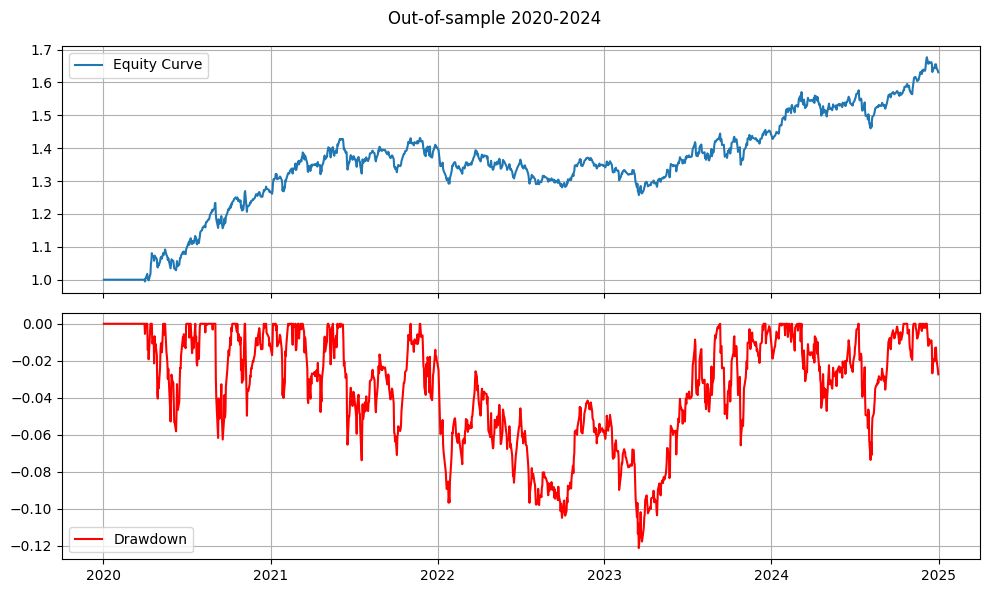

In [13]:
plot_equity_and_drawdown(ret_test, title="Out-of-sample 2020-2024")